# Question

Is the RF with 8 lags and a small number of components a better model than AutoARIMA for one dataset?

# Hypothesis

RF will have the better score.

# Conclusion

The hypothesis that RF will have a better score was correct.  It outperformed ARIMA drastically on the test set.  Random Forest has an RMSE of 4.04 and ARIMA has an RMSE of 7.64.

# Experiment

### Prepare Data

I read in the data and do a train test split.

In [7]:
def get_train_test_split(df, days_in_test_set):
    days_in_test_set = days_in_test_set
    split_point = len(df) - days_in_test_set
    train, test = df[0:split_point], df[split_point:]
    return train, test


df = pd.read_csv(
    "/Users/peterjmyers/Work/Spot-Check-RF-Vs-AutoARIMA/source_data/daily-total-female-births-in-cal.csv")
df = df.iloc[0:365]
df.columns = ['Date', 'x']
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df.drop(['Date'], axis=1, inplace=True)
days_in_test_set = 10
train, test = get_train_test_split(df, days_in_test_set)

### Improve Algorithm

I call this section improve algorithm because this project is an experiment to see if using 10 random forest models improves AutoARIMA.

I define functions for auto arima prediction and random forest prediction.  Auto arima works by using the pyramid autoarima function.  Each random forest model forecasts a single day ahead from the last day of the training dataset; one model predicts one day ahead, another two days ahead, etc.

I run the two functions and print the rmse scores.  Then I plot the results.

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2359.801, BIC=2378.975, Fit time=3.739 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2750.744, BIC=2758.413, Fit time=0.036 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2562.645, BIC=2577.984, Fit time=0.629 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2362.493, BIC=2377.832, Fit time=2.473 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2356.672, BIC=2379.681, Fit time=4.203 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=2460.522, BIC=2479.696, Fit time=2.652 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2358.761, BIC=2385.605, Fit time=8.436 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2580.349, BIC=2595.689, Fit time=0.576 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=2360.901, BIC=2391.580, Fit time=9.536 seconds
Fit ARIMA: order=(0, 1, 1) s

/Users/peterjmyers/Work/commons/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/peterjmyers/Work/commons/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/peterjmyers/Work/commons/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single featur

The AutoARIMA rmse is 7.635898530798698
The Random Forest rmse is 4.036077787087847


/Users/peterjmyers/Work/commons/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/peterjmyers/Work/commons/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


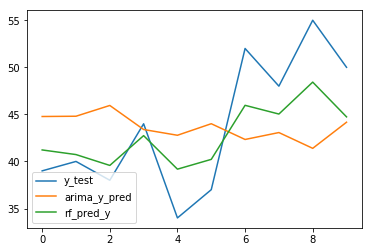

In [8]:
def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))


def auto_arima_prediction(train, days_in_test_set):
    stepwise_model = auto_arima(train, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,
                                start_P=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
    print(stepwise_model.aic())
    stepwise_model.fit(train)
    arima_y_pred = stepwise_model.predict(n_periods=days_in_test_set)
    return arima_y_pred


def random_forest_prediction(df, days_in_test_set):
    for i in range(1, 9):
        df['lag_{}'.format(i)] = df['x'].shift(i)
    df = df.dropna()
    for forecast_days_ahead in range(1, 11):
        df['y_{}'.format(forecast_days_ahead)
           ] = df['x'].shift(-1 * forecast_days_ahead)
    train, test = get_train_test_split(df, days_in_test_set)

    train_X = train[['x', 'lag_1', 'lag_2', 'lag_3',
                     'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8']]
    test_X = train.iloc[-1][['x', 'lag_1', 'lag_2', 'lag_3',
                             'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8']]
    test_X
    rf_pred_y = []
    for days_ahead in range(1, 11):
        model = ensemble.RandomForestRegressor(
            n_estimators=50, max_features="log2", min_samples_leaf=5, criterion="mse", bootstrap=True, random_state=2)
        train_y = train['y_{}'.format(days_ahead)]
        model = model.fit(train_X, train_y)
        rf_pred_y.append(model.predict(test_X))
    rf_pred_y = np.array(rf_pred_y)
    return rf_pred_y


arima_y_pred = auto_arima_prediction(train, days_in_test_set)
rf_pred_y = random_forest_prediction(df, days_in_test_set)

print("The AutoARIMA rmse is {}".format(rmse(test['x'], arima_y_pred)))
print("The Random Forest rmse is {}".format(rmse(test['x'], rf_pred_y)))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(test['x'].values)
ax.plot(arima_y_pred)
ax.plot(rf_pred_y)

ax.legend(['y_test', 'arima_y_pred', 'rf_pred_y'],
          loc='lower left')

### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandasql import sqldf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pyramid.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
def q(q): return sqldf(q, globals())